# Balance de clases con SMOTE

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.metrics import geometric_mean_score

In [2]:
df = pd.read_excel('df_objetivo/df_escalado.xlsx')

In [3]:
# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop("RIESGO_DESERCION", axis=1)
y = df["RIESGO_DESERCION"]

# Dividir antes del sobremuestreo para evitar fuga de datos (data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Aplicar SMOTE SOLO en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Mostrar nueva distribución
import pandas as pd
print("Distribución antes de SMOTE:")
print(pd.Series(y_train).value_counts())
print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Distribución antes de SMOTE:
0    766
1    132
Name: RIESGO_DESERCION, dtype: int64

Distribución después de SMOTE:
0    766
1    766
Name: RIESGO_DESERCION, dtype: int64


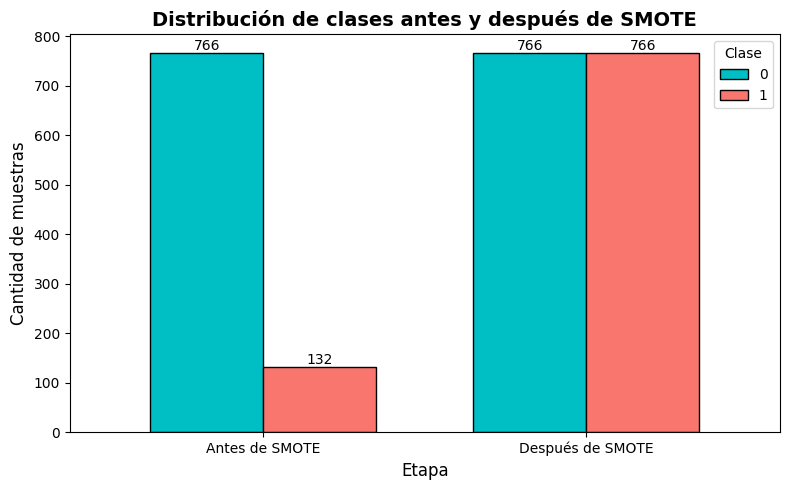

In [4]:
# Crear DataFrame con las distribuciones
distribucion = pd.DataFrame({
    'Antes de SMOTE': pd.Series(y_train).value_counts(),
    'Después de SMOTE': pd.Series(y_train_sm).value_counts()
}).T

# Estilo de colores
palette = ["#00BFC4", "#F8766D"]

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = distribucion.plot(kind='bar', stacked=False, color=palette, ax=ax, width=0.7, edgecolor='black')

# Personalización
ax.set_title('Distribución de clases antes y después de SMOTE', fontsize=14, fontweight='bold')
ax.set_xlabel('Etapa', fontsize=12)
ax.set_ylabel('Cantidad de muestras', fontsize=12)
ax.legend(title='Clase', labels=['0', '1'])
ax.tick_params(axis='x', labelrotation=0)

# Agregar etiquetas sobre cada barra
for container in bars.containers:
    bars.bar_label(container, label_type='edge', fontsize=10, color='black', padding=0)

# Ajustar y mostrar
plt.tight_layout()
plt.show()


# Modelos de machine learning

## Random forest

In [5]:
# Paso 1: Definir el modelo con hiperparámetros base
rf_model = RandomForestClassifier(
    n_estimators=20,           # Número de árboles
    max_depth=None,             # Sin límite de profundidad (los árboles crecen hasta puro criterio de partición)
    min_samples_split=2,        # Por defecto
    min_samples_leaf=1,         # Por defecto
    max_features='sqrt',        # Raíz cuadrada del total de features
    class_weight=None,          # Sin balanceo adicional (porque ya apliqué SMOTE)
    random_state=42             # Para resultados reproducibles
)


# print(f"AUC promedio (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Paso 2: Entrenar con datos balanceados
rf_model.fit(X_train_sm, y_train_sm)

# Paso 3: Predecir con los datos de prueba (sin balancear)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva


# Balanced Random Forest Classifier

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
from imblearn.metrics import geometric_mean_score
import shap
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [7]:
# Cargar el dataset escalado
df_brfc = pd.read_excel("df_objetivo/df_escalado.xlsx")

# Separar X y y
X = df_brfc.drop(columns=["RIESGO_DESERCION"])
y = df_brfc["RIESGO_DESERCION"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [8]:
# Crear el modelo base (sin optimización)
brf_base = BalancedRandomForestClassifier(
    n_estimators=100,           # Número de árboles por defecto
    max_depth=None,             # Profundidad sin límite
    max_features='sqrt',        # Raíz cuadrada de las características
    min_samples_split=2,        # Valor por defecto
    min_samples_leaf=1,         # Valor por defecto
    sampling_strategy='auto',   # Balanceo automático
    replacement=False,          # Sin reemplazo por defecto
    random_state=42             # Para reproducibilidad
)

# Entrenar el modelo con los datos originales (sin balancear externamente)
brf_base.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = brf_base.predict(X_test)
y_proba = brf_base.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva


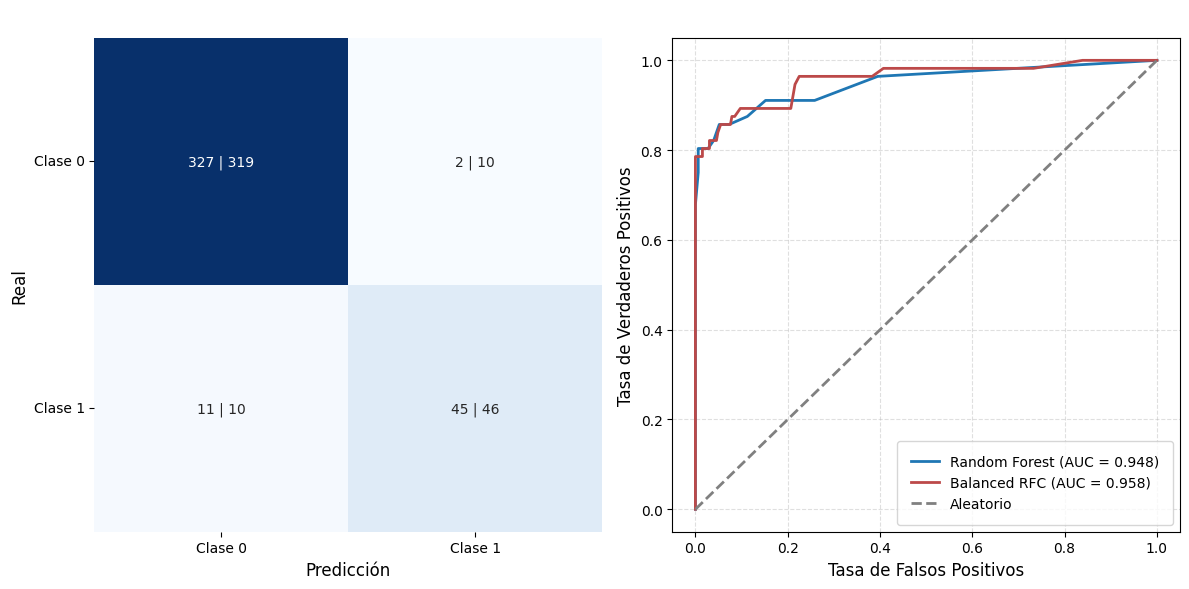

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las matrices de confusión de ambos modelos
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
cm_brf = confusion_matrix(y_test, brf_base.predict(X_test))

# Crear una matriz combinada con anotaciones
combined_cm = np.array([
    [f"{cm_rf[i, j]} | {cm_brf[i, j]}" for j in range(cm_rf.shape[1])]
    for i in range(cm_rf.shape[0])
])

# Calcular las curvas ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

fpr_brf, tpr_brf, _ = roc_curve(y_test, brf_base.predict_proba(X_test)[:, 1])
auc_brf = roc_auc_score(y_test, brf_base.predict_proba(X_test)[:, 1])

# Crear figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Matriz de confusión combinada
sns.heatmap(cm_rf + cm_brf, annot=combined_cm, fmt='', cmap='Blues', cbar=False, ax=axes[0])
# axes[0].set_title("Matrices de Confusión\nRandom Forest vs Balanced Random Forest", fontsize=14, pad=10)
axes[0].set_title(" ", fontsize=14, pad=10)
axes[0].set_xlabel("Predicción", fontsize=12)
axes[0].set_ylabel("Real", fontsize=12)
axes[0].set_xticklabels(["Clase 0", "Clase 1"], fontsize=10)
axes[0].set_yticklabels(["Clase 0", "Clase 1"], fontsize=10, rotation=0)

# Subplot 2: Curvas ROC
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='#1f77b4', lw=2)
axes[1].plot(fpr_brf, tpr_brf, label=f'Balanced RFC (AUC = {auc_brf:.3f})', color="#bc4949", lw=2)
axes[1].plot([0, 1], [0, 1], '--', color='gray', lw=2, label='Aleatorio')
# axes[1].set_title("Curvas ROC\nRandom Forest vs Balanced Random Forest", fontsize=14, pad=10)
axes[1].set_title(" ", fontsize=14, pad=10)
axes[1].set_xlabel("Tasa de Falsos Positivos", fontsize=12)
axes[1].set_ylabel("Tasa de Verdaderos Positivos", fontsize=12)
axes[1].legend(loc='lower right', fontsize=10, frameon=True, fancybox=True, borderpad=1)
axes[1].grid(True, alpha=0.4, linestyle='--')

# Ajustar diseño
plt.tight_layout()
plt.savefig("combined_confusion_roc.png", dpi=300, bbox_inches='tight')
plt.show()